In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class Embedding(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.position_embeddings = nn.Embedding(config.sequence_length, config.input_feature)
    self.norm_layer = nn.LayerNorm(config.input_feature , eps=1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_tensor):
      device = input_tensor.device  # input_tensor의 디바이스를 가져옵니다.
      input_pos = torch.arange(input_tensor.size(1), dtype=torch.long, device=device)  # 디바이스를 지정하여 input_pos를 생성합니다.
      pos_emb = self.position_embeddings(input_pos).unsqueeze(0)
      final_emb = input_tensor + pos_emb
      final_emb = self.norm_layer(final_emb)
      final_emb = self.dropout(final_emb)
      return final_emb

In [11]:
from math import sqrt
def scaled_dot_product(query,key,value):
  dim_k = query.size(-1)
  similiarity = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
  similiarity = F.softmax(similiarity, dim = -1) #여기 조심하자
  return torch.bmm(similiarity,value)

In [12]:
class Attention_head(nn.Module):
  def __init__(self, emb_dim, head_dim):
    super().__init__()
    self.query = nn.Linear(emb_dim, head_dim)
    self.key = nn.Linear(emb_dim, head_dim)
    self.value = nn.Linear(emb_dim, head_dim)

  def forward(self, final_emb):
    q = self.query(final_emb)
    k = self.key(final_emb)
    v = self.value(final_emb)
    return scaled_dot_product(q, k, v)

In [13]:
class Multihead_attention(nn.Module):
  def __init__(self,config):
    super().__init__()
    input_feature = config.input_feature
    self.attention_heads = nn.ModuleList([Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,3)])
    self.dense_layer = nn.Linear(input_feature, input_feature)

  def forward(self, final_emb):
    x = torch.cat([h(final_emb) for h in self.attention_heads],dim = -1)
    x = self.dense_layer(x)
    return x

In [14]:
class Feedforward(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.layer1 = nn.Linear(config.input_feature, config.feed_foward_dim)
    self.layer2 = nn.Linear(config.feed_foward_dim, config.input_feature)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.layer1(x)
    x = self.gelu(x)
    x = self.layer2(x)
    x = self.dropout(x)
    return x

In [15]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.Norm1 = nn.LayerNorm(config.input_feature)
    self.Norm2 = nn.LayerNorm(config.input_feature)
    self.attention = Multihead_attention(config)
    self.feedforward = Feedforward(config)

  def forward(self,x):
    norm = self.Norm1(x)
    x = x + self.attention(norm)
    x = x + self.feedforward(self.Norm2(x))
    return x

In [16]:
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        dim_k = q.size(-1)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (dim_k ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        weighted_average = torch.matmul(attention_weights, x)

        return weighted_average.mean(dim=1)

In [17]:
class TransformerEncoder(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding = Embedding(config)
    self.layers = nn.ModuleList([TransformerEncoderLayer(config) for i in range(config.num_layers)])
    self.attention = AttentionMechanism(config.input_feature)
    self.classifier = nn.Linear(config.input_feature, 2)

  def forward(self,x):
    x = self.embedding(x)
    for layer in self.layers:
      x = layer(x)
    x = self.attention(x)
    x = self.classifier(x)
    return x

# trainer 구현

In [18]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [19]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 4000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_feature = 19     # input feature 이거 바꾸면 모델 안 돌아감
  feed_foward_dim = 100  # feed forward dimension
  num_layers = 12        # encoder block 개수

config = Config()

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [21]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [22]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [23]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 4000
failure(1)의 개수 : 1569


In [24]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [25]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [26]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [27]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 3341
Total number of data samples in valid_loader: 1113
Total number of data samples in test_loader: 1114


In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [29]:
# model, optimizer, loss_function 구현하고 결합시키기
model = TransformerEncoder(config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [30]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/4000_Transformer') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 5/5 [00:00<00:00, 99.13it/s]


Model saved
TRAIN LOSS = 0.0028398467979899285, TRAIN ACC = 0.6563903023046992, 
VALID LOSS = 0.002457837049530523, VALID ACC = 0.7268643306379156, 
epoch 2


100%|██████████| 5/5 [00:00<00:00, 99.36it/s]


TRAIN LOSS = 0.002311975299081057, TRAIN ACC = 0.7312181981442681, 
VALID LOSS = 0.0025120099064260587, VALID ACC = 0.7097933513027853, 
epoch 3


100%|██████████| 5/5 [00:00<00:00, 98.38it/s]


Model saved
TRAIN LOSS = 0.002148854539837533, TRAIN ACC = 0.7539658784794971, 
VALID LOSS = 0.0024152611518698775, VALID ACC = 0.7331536388140162, 
epoch 4


100%|██████████| 5/5 [00:00<00:00, 97.83it/s]


TRAIN LOSS = 0.0021907628938417456, TRAIN ACC = 0.7479796468123316, 
VALID LOSS = 0.0024394129485775518, VALID ACC = 0.7053009883198562, 
epoch 5


100%|██████████| 5/5 [00:00<00:00, 98.01it/s]


TRAIN LOSS = 0.0021462129800842752, TRAIN ACC = 0.7587548638132295, 
VALID LOSS = 0.0024045610738464658, VALID ACC = 0.7133872416891285, 
epoch 6


100%|██████████| 5/5 [00:00<00:00, 97.76it/s]


Model saved
TRAIN LOSS = 0.0020760917460194107, TRAIN ACC = 0.7590541753965878, 
VALID LOSS = 0.0024104927802878462, VALID ACC = 0.7547169811320755, 
epoch 7


100%|██████████| 5/5 [00:00<00:00, 90.36it/s]


TRAIN LOSS = 0.0020627950308958736, TRAIN ACC = 0.7629452259802454, 
VALID LOSS = 0.002188254773670344, VALID ACC = 0.7493261455525606, 
epoch 8


100%|██████████| 5/5 [00:00<00:00, 98.18it/s]


Model saved
TRAIN LOSS = 0.0019998524992525203, TRAIN ACC = 0.7641424723136785, 
VALID LOSS = 0.0022088035418980846, VALID ACC = 0.7574123989218329, 
epoch 9


100%|██████████| 5/5 [00:00<00:00, 98.97it/s]


Model saved
TRAIN LOSS = 0.0020850409436675467, TRAIN ACC = 0.7644417838970368, 
VALID LOSS = 0.00217682259744711, VALID ACC = 0.7583108715184187, 
epoch 10


100%|██████████| 5/5 [00:00<00:00, 90.97it/s]


TRAIN LOSS = 0.002065496462899316, TRAIN ACC = 0.7572583058964382, 
VALID LOSS = 0.0021947787242865414, VALID ACC = 0.7511230907457322, 
epoch 11


100%|██████████| 5/5 [00:00<00:00, 90.87it/s]


Model saved
TRAIN LOSS = 0.0019220828885127242, TRAIN ACC = 0.7572583058964382, 
VALID LOSS = 0.0021203443849825794, VALID ACC = 0.7601078167115903, 
epoch 12


100%|██████████| 5/5 [00:00<00:00, 99.04it/s]


Model saved
TRAIN LOSS = 0.0019144346902413983, TRAIN ACC = 0.7626459143968871, 
VALID LOSS = 0.002269833155398099, VALID ACC = 0.7628032345013477, 
epoch 13


100%|██████████| 5/5 [00:00<00:00, 94.36it/s]


TRAIN LOSS = 0.002014359406317397, TRAIN ACC = 0.7707273271475606, 
VALID LOSS = 0.002177000527754627, VALID ACC = 0.7628032345013477, 
epoch 14


100%|██████████| 5/5 [00:00<00:00, 95.97it/s]


TRAIN LOSS = 0.001948162266609377, TRAIN ACC = 0.7752170008979348, 
VALID LOSS = 0.0022165103474931468, VALID ACC = 0.7556154537286612, 
epoch 15


100%|██████████| 5/5 [00:00<00:00, 99.51it/s]


TRAIN LOSS = 0.00198409861342274, TRAIN ACC = 0.764741095480395, 
VALID LOSS = 0.0021047407940284475, VALID ACC = 0.7529200359389039, 
epoch 16


100%|██████████| 5/5 [00:00<00:00, 100.05it/s]


TRAIN LOSS = 0.0020048549631262068, TRAIN ACC = 0.7623466028135288, 
VALID LOSS = 0.0023231727789889984, VALID ACC = 0.756513926325247, 
epoch 17


100%|██████████| 5/5 [00:00<00:00, 98.65it/s]


Model saved
TRAIN LOSS = 0.0019394070739626207, TRAIN ACC = 0.7695300808141275, 
VALID LOSS = 0.002061992830129111, VALID ACC = 0.7726864330637916, 
epoch 18


100%|██████████| 5/5 [00:00<00:00, 99.30it/s]


TRAIN LOSS = 0.0018770730859396236, TRAIN ACC = 0.7731218198144268, 
VALID LOSS = 0.0020583908727119767, VALID ACC = 0.7699910152740341, 
epoch 19


100%|██████████| 5/5 [00:00<00:00, 100.36it/s]


TRAIN LOSS = 0.0018975013068106958, TRAIN ACC = 0.7719245734809937, 
VALID LOSS = 0.002244888531229888, VALID ACC = 0.7619047619047619, 
epoch 20


100%|██████████| 5/5 [00:00<00:00, 99.52it/s]


TRAIN LOSS = 0.0019654006310045914, TRAIN ACC = 0.7746183777312182, 
VALID LOSS = 0.002061800092378395, VALID ACC = 0.7699910152740341, 
epoch 21


100%|██████████| 5/5 [00:00<00:00, 99.27it/s]


TRAIN LOSS = 0.0020447923140909743, TRAIN ACC = 0.7671355881472613, 
VALID LOSS = 0.0020973349838565303, VALID ACC = 0.7672955974842768, 
epoch 22


100%|██████████| 5/5 [00:00<00:00, 99.55it/s]


TRAIN LOSS = 0.0018671676984842365, TRAIN ACC = 0.7779108051481592, 
VALID LOSS = 0.0021737444432919236, VALID ACC = 0.7574123989218329, 
epoch 23


100%|██████████| 5/5 [00:00<00:00, 100.08it/s]


TRAIN LOSS = 0.0018910800793398572, TRAIN ACC = 0.7770128703980844, 
VALID LOSS = 0.002085900558401418, VALID ACC = 0.766397124887691, 
epoch 24


100%|██████████| 5/5 [00:00<00:00, 98.10it/s]


TRAIN LOSS = 0.0019393223054892145, TRAIN ACC = 0.7785094283148758, 
VALID LOSS = 0.0020774634754132924, VALID ACC = 0.7654986522911051, 
epoch 25


100%|██████████| 5/5 [00:00<00:00, 98.66it/s]


TRAIN LOSS = 0.0019435706573202023, TRAIN ACC = 0.7725231966477103, 
VALID LOSS = 0.002042116716115837, VALID ACC = 0.7699910152740341, 
epoch 26


100%|██████████| 5/5 [00:00<00:00, 100.92it/s]


TRAIN LOSS = 0.0019048119832997693, TRAIN ACC = 0.7725231966477103, 
VALID LOSS = 0.0021637747497678553, VALID ACC = 0.7681940700808625, 
epoch 27


100%|██████████| 5/5 [00:00<00:00, 98.64it/s]


Model saved
TRAIN LOSS = 0.0018938056761117368, TRAIN ACC = 0.7800059862316672, 
VALID LOSS = 0.0019942456178588044, VALID ACC = 0.7834681042228212, 
epoch 28


100%|██████████| 5/5 [00:00<00:00, 99.22it/s]


TRAIN LOSS = 0.0017725731826263857, TRAIN ACC = 0.7800059862316672, 
VALID LOSS = 0.002226520741403585, VALID ACC = 0.7735849056603774, 
epoch 29


100%|██████████| 5/5 [00:00<00:00, 99.69it/s]


TRAIN LOSS = 0.0018880553443215628, TRAIN ACC = 0.7806046093983837, 
VALID LOSS = 0.0020618956311800837, VALID ACC = 0.7601078167115903, 
epoch 30


100%|██████████| 5/5 [00:00<00:00, 98.45it/s]


TRAIN LOSS = 0.0018272536291900562, TRAIN ACC = 0.7818018557318168, 
VALID LOSS = 0.0022317832210314564, VALID ACC = 0.7448337825696316, 
epoch 31


100%|██████████| 5/5 [00:00<00:00, 100.20it/s]


TRAIN LOSS = 0.001832687035894294, TRAIN ACC = 0.7859922178988327, 
VALID LOSS = 0.0020435322059346875, VALID ACC = 0.7825696316262354, 
epoch 32


100%|██████████| 5/5 [00:00<00:00, 99.55it/s]


TRAIN LOSS = 0.0017499469133666517, TRAIN ACC = 0.7877880873989823, 
VALID LOSS = 0.002065084399345857, VALID ACC = 0.7771787960467206, 
epoch 33


100%|██████████| 5/5 [00:00<00:00, 99.72it/s]


Model saved
TRAIN LOSS = 0.001824101933245529, TRAIN ACC = 0.7934750074827895, 
VALID LOSS = 0.0020724849613100583, VALID ACC = 0.7879604672057502, 
epoch 34


100%|██████████| 5/5 [00:00<00:00, 99.69it/s]


TRAIN LOSS = 0.0018767581411337146, TRAIN ACC = 0.7889853337324154, 
VALID LOSS = 0.002101646788143833, VALID ACC = 0.7861635220125787, 
epoch 35


100%|██████████| 5/5 [00:00<00:00, 96.62it/s]


TRAIN LOSS = 0.0018900744271328335, TRAIN ACC = 0.7815025441484585, 
VALID LOSS = 0.002101219326980673, VALID ACC = 0.7699910152740341, 
epoch 36


100%|██████████| 5/5 [00:00<00:00, 100.86it/s]


Model saved
TRAIN LOSS = 0.001823383475163496, TRAIN ACC = 0.7868901526489075, 
VALID LOSS = 0.001864649402270527, VALID ACC = 0.7924528301886793, 
epoch 37


100%|██████████| 5/5 [00:00<00:00, 100.59it/s]


TRAIN LOSS = 0.0017657662019584038, TRAIN ACC = 0.792876384316073, 
VALID LOSS = 0.0019293089547033045, VALID ACC = 0.7789757412398922, 
epoch 38


100%|██████████| 5/5 [00:00<00:00, 95.37it/s]


TRAIN LOSS = 0.0017202831749001223, TRAIN ACC = 0.7919784495659982, 
VALID LOSS = 0.002066892273021194, VALID ACC = 0.7762803234501348, 
epoch 39


100%|██████████| 5/5 [00:00<00:00, 99.02it/s]


Model saved
TRAIN LOSS = 0.0017589197405724066, TRAIN ACC = 0.7892846453157737, 
VALID LOSS = 0.0018056100644405534, VALID ACC = 0.7960467205750225, 
epoch 40


100%|██████████| 5/5 [00:00<00:00, 100.40it/s]


TRAIN LOSS = 0.001765789546070253, TRAIN ACC = 0.7937743190661478, 
VALID LOSS = 0.0018675081759878674, VALID ACC = 0.788858939802336, 
epoch 41


100%|██████████| 5/5 [00:00<00:00, 100.29it/s]


TRAIN LOSS = 0.0017159967785001478, TRAIN ACC = 0.7967674348997306, 
VALID LOSS = 0.0018704649519513345, VALID ACC = 0.788858939802336, 
epoch 42


100%|██████████| 5/5 [00:00<00:00, 100.38it/s]


TRAIN LOSS = 0.0017176040255070732, TRAIN ACC = 0.7937743190661478, 
VALID LOSS = 0.0019466563162242414, VALID ACC = 0.784366576819407, 
epoch 43


100%|██████████| 5/5 [00:00<00:00, 100.11it/s]


TRAIN LOSS = 0.0017402752346351667, TRAIN ACC = 0.797066746483089, 
VALID LOSS = 0.00188101309971668, VALID ACC = 0.7960467205750225, 
epoch 44


100%|██████████| 5/5 [00:00<00:00, 98.24it/s]


TRAIN LOSS = 0.0017085798002224202, TRAIN ACC = 0.7997605507333134, 
VALID LOSS = 0.0018809783972819861, VALID ACC = 0.7942497753818508, 
epoch 45


100%|██████████| 5/5 [00:00<00:00, 100.73it/s]


Model saved
TRAIN LOSS = 0.0017097883419304042, TRAIN ACC = 0.7985633043998803, 
VALID LOSS = 0.00189823595018721, VALID ACC = 0.8005390835579514, 
epoch 46


100%|██████████| 5/5 [00:00<00:00, 99.58it/s]


Model saved
TRAIN LOSS = 0.0017084294595036168, TRAIN ACC = 0.8045495360670458, 
VALID LOSS = 0.0018982084774264107, VALID ACC = 0.8122192273135669, 
epoch 47


100%|██████████| 5/5 [00:00<00:00, 99.86it/s]


TRAIN LOSS = 0.0016798699323162638, TRAIN ACC = 0.7991619275665969, 
VALID LOSS = 0.0018497739465838602, VALID ACC = 0.7852650494159928, 
epoch 48


100%|██████████| 5/5 [00:00<00:00, 97.13it/s]


TRAIN LOSS = 0.0017518016596962257, TRAIN ACC = 0.80903920981742, 
VALID LOSS = 0.001803719799259388, VALID ACC = 0.8077268643306379, 
epoch 49


100%|██████████| 5/5 [00:00<00:00, 100.22it/s]


Model saved
TRAIN LOSS = 0.0016234730111378748, TRAIN ACC = 0.8072433403172703, 
VALID LOSS = 0.00170099408585856, VALID ACC = 0.825696316262354, 
epoch 50


100%|██████████| 5/5 [00:00<00:00, 98.84it/s]


TRAIN LOSS = 0.0015573973910461033, TRAIN ACC = 0.8144268183178689, 
VALID LOSS = 0.0021643561762084, VALID ACC = 0.7951482479784366, 
epoch 51


100%|██████████| 5/5 [00:00<00:00, 100.91it/s]


TRAIN LOSS = 0.001600528255760652, TRAIN ACC = 0.8063454055671955, 
VALID LOSS = 0.0019921801000271203, VALID ACC = 0.8005390835579514, 
epoch 52


100%|██████████| 5/5 [00:00<00:00, 98.89it/s]


TRAIN LOSS = 0.0016227893506791983, TRAIN ACC = 0.8096378329841365, 
VALID LOSS = 0.0018547773896737455, VALID ACC = 0.8077268643306379, 
epoch 53


100%|██████████| 5/5 [00:00<00:00, 100.50it/s]


TRAIN LOSS = 0.0015098372464835092, TRAIN ACC = 0.810236456150853, 
VALID LOSS = 0.0019283779869182411, VALID ACC = 0.8238993710691824, 
epoch 54


100%|██████████| 5/5 [00:00<00:00, 100.35it/s]


TRAIN LOSS = 0.0014628658070602806, TRAIN ACC = 0.8258006584854833, 
VALID LOSS = 0.0017754152510900917, VALID ACC = 0.8176100628930818, 
epoch 55


100%|██████████| 5/5 [00:00<00:00, 98.67it/s]


Model saved
TRAIN LOSS = 0.0014306012562241108, TRAIN ACC = 0.8234061658186171, 
VALID LOSS = 0.0018406372989284382, VALID ACC = 0.8265947888589398, 
epoch 56


100%|██████████| 5/5 [00:00<00:00, 98.75it/s]


TRAIN LOSS = 0.0015519382496216954, TRAIN ACC = 0.8207123615683927, 
VALID LOSS = 0.002142615636403991, VALID ACC = 0.8005390835579514, 
epoch 57


100%|██████████| 5/5 [00:00<00:00, 100.24it/s]


TRAIN LOSS = 0.0015836933065195777, TRAIN ACC = 0.8129302604010775, 
VALID LOSS = 0.0019769153933426546, VALID ACC = 0.8068283917340521, 
epoch 58


100%|██████████| 5/5 [00:00<00:00, 99.97it/s]


TRAIN LOSS = 0.0015922489725733475, TRAIN ACC = 0.8111343909009279, 
VALID LOSS = 0.0017144328446829522, VALID ACC = 0.8194070080862533, 
epoch 59


100%|██████████| 5/5 [00:00<00:00, 95.02it/s]


TRAIN LOSS = 0.0014854275120549914, TRAIN ACC = 0.829691709069141, 
VALID LOSS = 0.0018755821954636346, VALID ACC = 0.8086253369272237, 
epoch 60


100%|██████████| 5/5 [00:00<00:00, 100.42it/s]


TRAIN LOSS = 0.0014997301648313219, TRAIN ACC = 0.8293923974857828, 
VALID LOSS = 0.0018263631914503813, VALID ACC = 0.8149146451033243, 
epoch 61


100%|██████████| 5/5 [00:00<00:00, 89.51it/s]


TRAIN LOSS = 0.0014426258956554657, TRAIN ACC = 0.8335827596527986, 
VALID LOSS = 0.0018169977647810504, VALID ACC = 0.8122192273135669, 
epoch 62


100%|██████████| 5/5 [00:00<00:00, 96.56it/s]


TRAIN LOSS = 0.0014586764220811763, TRAIN ACC = 0.8305896438192159, 
VALID LOSS = 0.001778879576937529, VALID ACC = 0.8050314465408805, 
epoch 63


100%|██████████| 5/5 [00:00<00:00, 98.16it/s]


TRAIN LOSS = 0.0014488418296367527, TRAIN ACC = 0.8225082310685423, 
VALID LOSS = 0.0017617325309366122, VALID ACC = 0.8068283917340521, 
epoch 64


100%|██████████| 5/5 [00:00<00:00, 97.24it/s]


TRAIN LOSS = 0.0014452066509996978, TRAIN ACC = 0.8347800059862317, 
VALID LOSS = 0.00194438684125902, VALID ACC = 0.8068283917340521, 
epoch 65


100%|██████████| 5/5 [00:00<00:00, 98.26it/s]


Model saved
TRAIN LOSS = 0.0016002452719607635, TRAIN ACC = 0.80903920981742, 
VALID LOSS = 0.0016683562853694069, VALID ACC = 0.8328840970350404, 
epoch 66


100%|██████████| 5/5 [00:00<00:00, 95.80it/s]


TRAIN LOSS = 0.001747759248067861, TRAIN ACC = 0.8084405866507034, 
VALID LOSS = 0.001966998396108307, VALID ACC = 0.7789757412398922, 
epoch 67


100%|██████████| 5/5 [00:00<00:00, 99.18it/s]


TRAIN LOSS = 0.0014706240625161676, TRAIN ACC = 0.8290930859024245, 
VALID LOSS = 0.0015934475723516802, VALID ACC = 0.8328840970350404, 
epoch 68


100%|██████████| 5/5 [00:00<00:00, 99.83it/s]


TRAIN LOSS = 0.001437082917916493, TRAIN ACC = 0.8269979048189164, 
VALID LOSS = 0.0018915097829145242, VALID ACC = 0.8131176999101527, 
epoch 69


100%|██████████| 5/5 [00:00<00:00, 98.43it/s]


TRAIN LOSS = 0.001417696119175454, TRAIN ACC = 0.8422627955701886, 
VALID LOSS = 0.001851794586884258, VALID ACC = 0.8032345013477089, 
epoch 70


100%|██████████| 5/5 [00:00<00:00, 49.01it/s]


TRAIN LOSS = 0.001408833402675342, TRAIN ACC = 0.832984136486082, 
VALID LOSS = 0.0018168847141025951, VALID ACC = 0.8059299191374663, 
epoch 71


100%|██████████| 5/5 [00:00<00:00, 100.03it/s]


TRAIN LOSS = 0.0014821759725323483, TRAIN ACC = 0.8395689913199641, 
VALID LOSS = 0.0019044453564358529, VALID ACC = 0.7978436657681941, 
epoch 72


100%|██████████| 5/5 [00:00<00:00, 99.56it/s]


TRAIN LOSS = 0.0015568941323138468, TRAIN ACC = 0.8269979048189164, 
VALID LOSS = 0.0018177645921921366, VALID ACC = 0.7987421383647799, 
epoch 73


100%|██████████| 5/5 [00:00<00:00, 100.06it/s]


TRAIN LOSS = 0.0015325331377504972, TRAIN ACC = 0.8213109847351092, 
VALID LOSS = 0.002022532573821624, VALID ACC = 0.8050314465408805, 
epoch 74


100%|██████████| 5/5 [00:00<00:00, 99.56it/s]


TRAIN LOSS = 0.0015157883804524526, TRAIN ACC = 0.818916492068243, 
VALID LOSS = 0.0017685289063757855, VALID ACC = 0.8005390835579514, 
epoch 75


100%|██████████| 5/5 [00:00<00:00, 95.32it/s]


TRAIN LOSS = 0.0014612226117267397, TRAIN ACC = 0.8392696797366058, 
VALID LOSS = 0.001734860234718974, VALID ACC = 0.8149146451033243, 
epoch 76


100%|██████████| 5/5 [00:00<00:00, 99.68it/s]


TRAIN LOSS = 0.0013965151153685481, TRAIN ACC = 0.8398683029033224, 
VALID LOSS = 0.0021586358707870114, VALID ACC = 0.7816711590296496, 
epoch 77


100%|██████████| 5/5 [00:00<00:00, 97.63it/s]


TRAIN LOSS = 0.001392519356283161, TRAIN ACC = 0.838371744986531, 
VALID LOSS = 0.0019885644330061565, VALID ACC = 0.7942497753818508, 
epoch 78


100%|██████████| 5/5 [00:00<00:00, 99.11it/s]


TRAIN LOSS = 0.0012945585963041687, TRAIN ACC = 0.8563304399880275, 
VALID LOSS = 0.001852450532519057, VALID ACC = 0.8158131176999102, 
epoch 79


100%|██████████| 5/5 [00:00<00:00, 99.80it/s]


TRAIN LOSS = 0.0012998844880752311, TRAIN ACC = 0.8455552229871296, 
VALID LOSS = 0.0017231417366329444, VALID ACC = 0.8185085354896675, 
epoch 80


100%|██████████| 5/5 [00:00<00:00, 99.32it/s]


TRAIN LOSS = 0.0013386929411618375, TRAIN ACC = 0.8521400778210116, 
VALID LOSS = 0.0017759314230295954, VALID ACC = 0.8221024258760108, 
epoch 81


100%|██████████| 5/5 [00:00<00:00, 99.01it/s]


TRAIN LOSS = 0.001342661734542173, TRAIN ACC = 0.8446572882370548, 
VALID LOSS = 0.0021318393790389864, VALID ACC = 0.7969451931716083, 
epoch 82


100%|██████████| 5/5 [00:00<00:00, 99.56it/s]


TRAIN LOSS = 0.0014006103612248394, TRAIN ACC = 0.8374738102364562, 
VALID LOSS = 0.002043173025024976, VALID ACC = 0.8238993710691824, 
epoch 83


100%|██████████| 5/5 [00:00<00:00, 100.11it/s]


Model saved
TRAIN LOSS = 0.0013538562263139384, TRAIN ACC = 0.8488476504040706, 
VALID LOSS = 0.001601995349680103, VALID ACC = 0.8463611859838275, 
epoch 84


100%|██████████| 5/5 [00:00<00:00, 100.38it/s]


TRAIN LOSS = 0.0012674276181517587, TRAIN ACC = 0.8554325052379527, 
VALID LOSS = 0.0019794049984896817, VALID ACC = 0.8050314465408805, 
epoch 85


100%|██████████| 5/5 [00:00<00:00, 99.72it/s]


TRAIN LOSS = 0.001271832693090556, TRAIN ACC = 0.8497455851541454, 
VALID LOSS = 0.0016463621982238579, VALID ACC = 0.8463611859838275, 
epoch 86


100%|██████████| 5/5 [00:00<00:00, 94.17it/s]


TRAIN LOSS = 0.0012849420888878492, TRAIN ACC = 0.8443579766536965, 
VALID LOSS = 0.0018879345485142299, VALID ACC = 0.8194070080862533, 
epoch 87


100%|██████████| 5/5 [00:00<00:00, 100.41it/s]


TRAIN LOSS = 0.0012892047397678606, TRAIN ACC = 0.8545345704878778, 
VALID LOSS = 0.0016815788501677808, VALID ACC = 0.821203953279425, 
epoch 88


100%|██████████| 5/5 [00:00<00:00, 100.27it/s]


TRAIN LOSS = 0.0013343494511478427, TRAIN ACC = 0.8524393894043699, 
VALID LOSS = 0.0021099091807894096, VALID ACC = 0.8005390835579514, 
epoch 89


100%|██████████| 5/5 [00:00<00:00, 99.97it/s]


TRAIN LOSS = 0.0013266502918864538, TRAIN ACC = 0.8524393894043699, 
VALID LOSS = 0.002123975127212442, VALID ACC = 0.7897574123989218, 
epoch 90


100%|██████████| 5/5 [00:00<00:00, 67.64it/s]


TRAIN LOSS = 0.0012883864960888838, TRAIN ACC = 0.8530380125710865, 
VALID LOSS = 0.002274028294169999, VALID ACC = 0.7690925426774483, 
epoch 91


100%|██████████| 5/5 [00:00<00:00, 100.62it/s]


TRAIN LOSS = 0.0013572058699795387, TRAIN ACC = 0.8461538461538461, 
VALID LOSS = 0.0019607565634334185, VALID ACC = 0.8122192273135669, 
epoch 92


100%|██████████| 5/5 [00:00<00:00, 100.29it/s]


TRAIN LOSS = 0.0012531679695646622, TRAIN ACC = 0.8524393894043699, 
VALID LOSS = 0.0018160387083740782, VALID ACC = 0.8265947888589398, 
epoch 93


100%|██████████| 5/5 [00:00<00:00, 97.98it/s]


TRAIN LOSS = 0.001244097270140638, TRAIN ACC = 0.8539359473211613, 
VALID LOSS = 0.001793224133571203, VALID ACC = 0.8337825696316262, 
epoch 94


100%|██████████| 5/5 [00:00<00:00, 100.31it/s]


TRAIN LOSS = 0.0012393912104781035, TRAIN ACC = 0.8593235558216102, 
VALID LOSS = 0.0018127751532483508, VALID ACC = 0.8373764600179695, 
epoch 95


100%|██████████| 5/5 [00:00<00:00, 100.49it/s]


Model saved
TRAIN LOSS = 0.0013466220403709514, TRAIN ACC = 0.8584256210715354, 
VALID LOSS = 0.0015712414147718897, VALID ACC = 0.8490566037735849, 
epoch 96


100%|██████████| 5/5 [00:00<00:00, 97.04it/s]


TRAIN LOSS = 0.0015745901733199767, TRAIN ACC = 0.827596527985633, 
VALID LOSS = 0.0023211310119748865, VALID ACC = 0.7681940700808625, 
epoch 97


100%|██████████| 5/5 [00:00<00:00, 98.71it/s]


TRAIN LOSS = 0.0013646626177661186, TRAIN ACC = 0.8341813828195151, 
VALID LOSS = 0.0016318424692693745, VALID ACC = 0.8158131176999102, 
epoch 98


100%|██████████| 5/5 [00:00<00:00, 97.17it/s]


TRAIN LOSS = 0.0013216066435403147, TRAIN ACC = 0.8557318168213109, 
VALID LOSS = 0.0017857358783403175, VALID ACC = 0.8238993710691824, 
epoch 99


100%|██████████| 5/5 [00:00<00:00, 98.42it/s]


TRAIN LOSS = 0.0012624816770005533, TRAIN ACC = 0.8560311284046692, 
VALID LOSS = 0.001584724167500759, VALID ACC = 0.8463611859838275, 
epoch 100


100%|██████████| 5/5 [00:00<00:00, 96.85it/s]


TRAIN LOSS = 0.0013143247881537959, TRAIN ACC = 0.8542352589045196, 
VALID LOSS = 0.0020812967823950535, VALID ACC = 0.7915543575920935, 
epoch 101


100%|██████████| 5/5 [00:00<00:00, 90.12it/s]


TRAIN LOSS = 0.0012491044661699744, TRAIN ACC = 0.8575276863214606, 
VALID LOSS = 0.00190459642984368, VALID ACC = 0.825696316262354, 
epoch 102


100%|██████████| 5/5 [00:00<00:00, 95.16it/s]


TRAIN LOSS = 0.001286009557944363, TRAIN ACC = 0.8593235558216102, 
VALID LOSS = 0.001879674324770822, VALID ACC = 0.8113207547169812, 
epoch 103


100%|██████████| 5/5 [00:00<00:00, 96.98it/s]


TRAIN LOSS = 0.0012804731231576417, TRAIN ACC = 0.856929063154744, 
VALID LOSS = 0.0017994004707559206, VALID ACC = 0.8247978436657682, 
epoch 104


100%|██████████| 5/5 [00:00<00:00, 96.70it/s]


TRAIN LOSS = 0.0012765176119257755, TRAIN ACC = 0.8530380125710865, 
VALID LOSS = 0.0021658696682733776, VALID ACC = 0.7915543575920935, 
epoch 105


100%|██████████| 5/5 [00:00<00:00, 82.07it/s]


TRAIN LOSS = 0.0011916955639166378, TRAIN ACC = 0.8647111643220593, 
VALID LOSS = 0.0018349391377304228, VALID ACC = 0.8265947888589398, 
epoch 106


100%|██████████| 5/5 [00:00<00:00, 94.30it/s]


TRAIN LOSS = 0.0012634914904716878, TRAIN ACC = 0.8596228674049686, 
VALID LOSS = 0.0018871258157711253, VALID ACC = 0.8158131176999102, 
epoch 107


100%|██████████| 5/5 [00:00<00:00, 100.21it/s]


TRAIN LOSS = 0.0011935451410017269, TRAIN ACC = 0.8650104759054176, 
VALID LOSS = 0.002275181802028166, VALID ACC = 0.7915543575920935, 
epoch 108


100%|██████████| 5/5 [00:00<00:00, 99.01it/s]


TRAIN LOSS = 0.0011738850546967872, TRAIN ACC = 0.8674049685722838, 
VALID LOSS = 0.0024774895524078944, VALID ACC = 0.8023360287511231, 
epoch 109


100%|██████████| 5/5 [00:00<00:00, 100.33it/s]


TRAIN LOSS = 0.0012295113793392804, TRAIN ACC = 0.867704280155642, 
VALID LOSS = 0.0018151099094911834, VALID ACC = 0.8238993710691824, 
epoch 110


100%|██████████| 5/5 [00:00<00:00, 99.41it/s]


TRAIN LOSS = 0.0011543452035021333, TRAIN ACC = 0.8695001496557917, 
VALID LOSS = 0.0020817821880556504, VALID ACC = 0.8158131176999102, 
epoch 111


100%|██████████| 5/5 [00:00<00:00, 99.62it/s]


TRAIN LOSS = 0.0011755774136040604, TRAIN ACC = 0.8751870697395989, 
VALID LOSS = 0.0020099221481895617, VALID ACC = 0.8158131176999102, 
epoch 112


100%|██████████| 5/5 [00:00<00:00, 100.68it/s]


TRAIN LOSS = 0.0011806587407917936, TRAIN ACC = 0.8712960191559413, 
VALID LOSS = 0.0021099318605441826, VALID ACC = 0.7987421383647799, 
epoch 113


100%|██████████| 5/5 [00:00<00:00, 67.42it/s]


TRAIN LOSS = 0.0011680074051731684, TRAIN ACC = 0.8674049685722838, 
VALID LOSS = 0.0022720481400434114, VALID ACC = 0.8301886792452831, 
epoch 114


100%|██████████| 5/5 [00:00<00:00, 90.47it/s]


TRAIN LOSS = 0.0013808319442681087, TRAIN ACC = 0.8602214905716852, 
VALID LOSS = 0.0019075558566875748, VALID ACC = 0.8230008984725966, 
epoch 115


100%|██████████| 5/5 [00:00<00:00, 100.19it/s]


TRAIN LOSS = 0.0012028025844003653, TRAIN ACC = 0.8620173600718348, 
VALID LOSS = 0.001929361838429015, VALID ACC = 0.8014375561545373, 
epoch 116


100%|██████████| 5/5 [00:00<00:00, 99.46it/s]


TRAIN LOSS = 0.0012126562481902738, TRAIN ACC = 0.8614187369051183, 
VALID LOSS = 0.0018974969704089032, VALID ACC = 0.8185085354896675, 
epoch 117


100%|██████████| 5/5 [00:00<00:00, 97.43it/s]


TRAIN LOSS = 0.0012975532658547565, TRAIN ACC = 0.8662077222388507, 
VALID LOSS = 0.0019441892837257077, VALID ACC = 0.8265947888589398, 
epoch 118


100%|██████████| 5/5 [00:00<00:00, 97.32it/s]


TRAIN LOSS = 0.0011689858508302723, TRAIN ACC = 0.873091888656091, 
VALID LOSS = 0.002193238964406414, VALID ACC = 0.8113207547169812, 
epoch 119


100%|██████████| 5/5 [00:00<00:00, 96.68it/s]


TRAIN LOSS = 0.0011688961628774296, TRAIN ACC = 0.8709967075725831, 
VALID LOSS = 0.00226989878477112, VALID ACC = 0.7987421383647799, 
epoch 120


100%|██████████| 5/5 [00:00<00:00, 97.93it/s]


TRAIN LOSS = 0.0011754718388101006, TRAIN ACC = 0.8641125411553428, 
VALID LOSS = 0.0022517640582099224, VALID ACC = 0.8230008984725966, 
epoch 121


100%|██████████| 5/5 [00:00<00:00, 98.07it/s]


TRAIN LOSS = 0.0011608439161191618, TRAIN ACC = 0.8745884465728824, 
VALID LOSS = 0.0019513580944767325, VALID ACC = 0.816711590296496, 
epoch 122


100%|██████████| 5/5 [00:00<00:00, 98.20it/s]


TRAIN LOSS = 0.001147682364027645, TRAIN ACC = 0.8718946423226579, 
VALID LOSS = 0.0019666114746720964, VALID ACC = 0.8131176999101527, 
epoch 123


100%|██████████| 5/5 [00:00<00:00, 96.26it/s]


TRAIN LOSS = 0.0011954145253471756, TRAIN ACC = 0.8686022149057169, 
VALID LOSS = 0.0023308744970357642, VALID ACC = 0.8140161725067385, 
epoch 124


100%|██████████| 5/5 [00:00<00:00, 91.06it/s]


TRAIN LOSS = 0.0011150221318336562, TRAIN ACC = 0.8668063454055672, 
VALID LOSS = 0.001973706917621376, VALID ACC = 0.8238993710691824, 
epoch 125


100%|██████████| 5/5 [00:00<00:00, 99.04it/s]


TRAIN LOSS = 0.0011477513794626386, TRAIN ACC = 0.8727925770727327, 
VALID LOSS = 0.0023769565187695854, VALID ACC = 0.7951482479784366, 
epoch 126


100%|██████████| 5/5 [00:00<00:00, 98.96it/s]


TRAIN LOSS = 0.0011233553553512445, TRAIN ACC = 0.8769829392397486, 
VALID LOSS = 0.0019094421321598132, VALID ACC = 0.8095238095238095, 
epoch 127


100%|██████████| 5/5 [00:00<00:00, 92.55it/s]


TRAIN LOSS = 0.001144874032583468, TRAIN ACC = 0.8742891349895241, 
VALID LOSS = 0.0020742965837051925, VALID ACC = 0.8068283917340521, 
epoch 128


100%|██████████| 5/5 [00:00<00:00, 96.10it/s]


TRAIN LOSS = 0.0011613095941318077, TRAIN ACC = 0.8790781203232565, 
VALID LOSS = 0.002114873315874564, VALID ACC = 0.8122192273135669, 
epoch 129


100%|██████████| 5/5 [00:00<00:00, 99.97it/s]


TRAIN LOSS = 0.0011853897323582708, TRAIN ACC = 0.8745884465728824, 
VALID LOSS = 0.0021686597065355795, VALID ACC = 0.8032345013477089, 
epoch 130


100%|██████████| 5/5 [00:00<00:00, 98.89it/s]


TRAIN LOSS = 0.0011785656115638392, TRAIN ACC = 0.8668063454055672, 
VALID LOSS = 0.002143387230044534, VALID ACC = 0.8068283917340521, 
epoch 131


100%|██████████| 5/5 [00:00<00:00, 100.04it/s]


TRAIN LOSS = 0.0011325199084523123, TRAIN ACC = 0.8811733014067644, 
VALID LOSS = 0.0018606481794184216, VALID ACC = 0.8247978436657682, 
epoch 132


100%|██████████| 5/5 [00:00<00:00, 98.20it/s]


TRAIN LOSS = 0.0011705424267529942, TRAIN ACC = 0.8727925770727327, 
VALID LOSS = 0.0022827248956743705, VALID ACC = 0.8014375561545373, 
epoch 133


100%|██████████| 5/5 [00:00<00:00, 99.61it/s]


TRAIN LOSS = 0.0011059296047284338, TRAIN ACC = 0.8778808739898234, 
VALID LOSS = 0.002149764150514971, VALID ACC = 0.8104222821203954, 
epoch 134


100%|██████████| 5/5 [00:00<00:00, 100.15it/s]


TRAIN LOSS = 0.0011253808874528732, TRAIN ACC = 0.8686022149057169, 
VALID LOSS = 0.0022560283876386505, VALID ACC = 0.8095238095238095, 
epoch 135


100%|██████████| 5/5 [00:00<00:00, 99.37it/s]


TRAIN LOSS = 0.001082993515306374, TRAIN ACC = 0.8775815624064651, 
VALID LOSS = 0.0018842259400188655, VALID ACC = 0.8310871518418689, 
epoch 136


100%|██████████| 5/5 [00:00<00:00, 99.36it/s]


TRAIN LOSS = 0.001175435355272667, TRAIN ACC = 0.8736905118228075, 
VALID LOSS = 0.0023641389495921584, VALID ACC = 0.8032345013477089, 
epoch 137


100%|██████████| 5/5 [00:00<00:00, 99.50it/s]


TRAIN LOSS = 0.0012052004448277834, TRAIN ACC = 0.8841664172403472, 
VALID LOSS = 0.0019293218877866048, VALID ACC = 0.8176100628930818, 
epoch 138


100%|██████████| 5/5 [00:00<00:00, 99.00it/s]


TRAIN LOSS = 0.0012968195498043176, TRAIN ACC = 0.8680035917390003, 
VALID LOSS = 0.0021540109412903625, VALID ACC = 0.8059299191374663, 
epoch 139


100%|██████████| 5/5 [00:00<00:00, 98.66it/s]


TRAIN LOSS = 0.001165558726478572, TRAIN ACC = 0.8647111643220593, 
VALID LOSS = 0.0022447074145105434, VALID ACC = 0.825696316262354, 
epoch 140


100%|██████████| 5/5 [00:00<00:00, 98.53it/s]


TRAIN LOSS = 0.0011097409480062654, TRAIN ACC = 0.8793774319066148, 
VALID LOSS = 0.0019811060872039384, VALID ACC = 0.8185085354896675, 
epoch 141


100%|██████████| 5/5 [00:00<00:00, 99.41it/s]


TRAIN LOSS = 0.0011445638511538398, TRAIN ACC = 0.8811733014067644, 
VALID LOSS = 0.002112147594933454, VALID ACC = 0.8140161725067385, 
epoch 142


100%|██████████| 5/5 [00:00<00:00, 99.53it/s]


TRAIN LOSS = 0.0011809210386935624, TRAIN ACC = 0.8724932654893744, 
VALID LOSS = 0.0022270768372089286, VALID ACC = 0.8086253369272237, 
epoch 143


100%|██████████| 5/5 [00:00<00:00, 98.40it/s]


TRAIN LOSS = 0.0012103695733502254, TRAIN ACC = 0.8700987728225082, 
VALID LOSS = 0.001964310805002848, VALID ACC = 0.8283917340521114, 
epoch 144


100%|██████████| 5/5 [00:00<00:00, 100.21it/s]


TRAIN LOSS = 0.0010808528727380433, TRAIN ACC = 0.87847949715654, 
VALID LOSS = 0.0021362910641278647, VALID ACC = 0.8104222821203954, 
epoch 145


100%|██████████| 5/5 [00:00<00:00, 99.36it/s]


TRAIN LOSS = 0.00107053178704024, TRAIN ACC = 0.8772822508231068, 
VALID LOSS = 0.0024660199693163987, VALID ACC = 0.8059299191374663, 
epoch 146


100%|██████████| 5/5 [00:00<00:00, 99.79it/s]


TRAIN LOSS = 0.001222042918240942, TRAIN ACC = 0.8916492068243042, 
VALID LOSS = 0.0023485095460245658, VALID ACC = 0.8095238095238095, 
epoch 147


100%|██████████| 5/5 [00:00<00:00, 98.51it/s]


TRAIN LOSS = 0.0012119620485385712, TRAIN ACC = 0.8671056569889255, 
VALID LOSS = 0.0021324221710846, VALID ACC = 0.8104222821203954, 
epoch 148


100%|██████████| 5/5 [00:00<00:00, 100.45it/s]


TRAIN LOSS = 0.0010530019423733996, TRAIN ACC = 0.8853636635737803, 
VALID LOSS = 0.0023539940034175712, VALID ACC = 0.8050314465408805, 
epoch 149


100%|██████████| 5/5 [00:00<00:00, 97.51it/s]


TRAIN LOSS = 0.0010540968276040706, TRAIN ACC = 0.8832684824902723, 
VALID LOSS = 0.0024846057739754787, VALID ACC = 0.8059299191374663, 
epoch 150


100%|██████████| 5/5 [00:00<00:00, 100.34it/s]


TRAIN LOSS = 0.0010448286376182137, TRAIN ACC = 0.8838671056569889, 
VALID LOSS = 0.0021721598594336496, VALID ACC = 0.821203953279425, 
epoch 151


100%|██████████| 5/5 [00:00<00:00, 98.35it/s]


TRAIN LOSS = 0.0010399194676802565, TRAIN ACC = 0.8877581562406465, 
VALID LOSS = 0.002553525050266948, VALID ACC = 0.8140161725067385, 
epoch 152


100%|██████████| 5/5 [00:00<00:00, 100.31it/s]


TRAIN LOSS = 0.0010413480479358308, TRAIN ACC = 0.8841664172403472, 
VALID LOSS = 0.0021480373830701036, VALID ACC = 0.8230008984725966, 
epoch 153


100%|██████████| 5/5 [00:00<00:00, 100.07it/s]


TRAIN LOSS = 0.001040698244021489, TRAIN ACC = 0.8835677940736306, 
VALID LOSS = 0.0023126773542899433, VALID ACC = 0.816711590296496, 
epoch 154


100%|██████████| 5/5 [00:00<00:00, 98.60it/s]


TRAIN LOSS = 0.001042725943726931, TRAIN ACC = 0.8919485184076624, 
VALID LOSS = 0.0022928205461836245, VALID ACC = 0.8337825696316262, 
epoch 155


100%|██████████| 5/5 [00:00<00:00, 100.53it/s]


TRAIN LOSS = 0.0009897327448072208, TRAIN ACC = 0.8865609099072134, 
VALID LOSS = 0.0021375606484168946, VALID ACC = 0.825696316262354, 
epoch 156


100%|██████████| 5/5 [00:00<00:00, 100.15it/s]


TRAIN LOSS = 0.0009725985926484248, TRAIN ACC = 0.8943430110745286, 
VALID LOSS = 0.002244574067192043, VALID ACC = 0.8203054806828391, 
epoch 157


100%|██████████| 5/5 [00:00<00:00, 99.11it/s]


TRAIN LOSS = 0.0009538889448644872, TRAIN ACC = 0.8970368153247531, 
VALID LOSS = 0.002367850503510221, VALID ACC = 0.8077268643306379, 
epoch 158


100%|██████████| 5/5 [00:00<00:00, 99.96it/s]


TRAIN LOSS = 0.0010109294481314573, TRAIN ACC = 0.892547141574379, 
VALID LOSS = 0.002355899263477925, VALID ACC = 0.8122192273135669, 
epoch 159


100%|██████████| 5/5 [00:00<00:00, 93.39it/s]


TRAIN LOSS = 0.0010251373685929847, TRAIN ACC = 0.8859622867404968, 
VALID LOSS = 0.002376671241193019, VALID ACC = 0.8059299191374663, 
epoch 160


100%|██████████| 5/5 [00:00<00:00, 99.72it/s]


TRAIN LOSS = 0.001089422026104429, TRAIN ACC = 0.8895540257407961, 
VALID LOSS = 0.0021790507293882825, VALID ACC = 0.8185085354896675, 
epoch 161


100%|██████████| 5/5 [00:00<00:00, 100.33it/s]


TRAIN LOSS = 0.0011128102393251663, TRAIN ACC = 0.8748877581562406, 
VALID LOSS = 0.002395463948408334, VALID ACC = 0.8104222821203954, 
epoch 162


100%|██████████| 5/5 [00:00<00:00, 99.70it/s]


TRAIN LOSS = 0.0010214786986611055, TRAIN ACC = 0.8961388805746783, 
VALID LOSS = 0.0030223996063019924, VALID ACC = 0.8059299191374663, 
epoch 163


100%|██████████| 5/5 [00:00<00:00, 100.49it/s]


TRAIN LOSS = 0.0010362145822942347, TRAIN ACC = 0.8898533373241544, 
VALID LOSS = 0.0019201058476011922, VALID ACC = 0.8265947888589398, 
epoch 164


100%|██████████| 5/5 [00:00<00:00, 99.99it/s]


TRAIN LOSS = 0.0009946109193486748, TRAIN ACC = 0.8940436994911704, 
VALID LOSS = 0.002539380835929864, VALID ACC = 0.8014375561545373, 
epoch 165


100%|██████████| 5/5 [00:00<00:00, 99.15it/s]


TRAIN LOSS = 0.0010200166944899411, TRAIN ACC = 0.8940436994911704, 
VALID LOSS = 0.0020449518996750247, VALID ACC = 0.8203054806828391, 
epoch 166


100%|██████████| 5/5 [00:00<00:00, 98.25it/s]


TRAIN LOSS = 0.0010029969101928373, TRAIN ACC = 0.8919485184076624, 
VALID LOSS = 0.0026067296663920083, VALID ACC = 0.7996406109613656, 
epoch 167


100%|██████████| 5/5 [00:00<00:00, 96.92it/s]


TRAIN LOSS = 0.0009388217947255419, TRAIN ACC = 0.8985333732415445, 
VALID LOSS = 0.00240605191293324, VALID ACC = 0.8283917340521114, 
epoch 168


100%|██████████| 5/5 [00:00<00:00, 100.17it/s]


TRAIN LOSS = 0.0009934011867966206, TRAIN ACC = 0.8979347500748279, 
VALID LOSS = 0.002875838050516682, VALID ACC = 0.8149146451033243, 
epoch 169


100%|██████████| 5/5 [00:00<00:00, 99.78it/s]


TRAIN LOSS = 0.0009968424630143692, TRAIN ACC = 0.8919485184076624, 
VALID LOSS = 0.0023258618160292358, VALID ACC = 0.8319856244384546, 
epoch 170


100%|██████████| 5/5 [00:00<00:00, 99.21it/s]


TRAIN LOSS = 0.000951589003486285, TRAIN ACC = 0.89583956899132, 
VALID LOSS = 0.002948497826198362, VALID ACC = 0.8131176999101527, 
epoch 171


100%|██████████| 5/5 [00:00<00:00, 99.94it/s]


TRAIN LOSS = 0.0010123914701429821, TRAIN ACC = 0.8895540257407961, 
VALID LOSS = 0.0029255266887908142, VALID ACC = 0.7960467205750225, 
epoch 172


100%|██████████| 5/5 [00:00<00:00, 100.10it/s]


TRAIN LOSS = 0.000970737577662144, TRAIN ACC = 0.892547141574379, 
VALID LOSS = 0.0026432348872130773, VALID ACC = 0.8113207547169812, 
epoch 173


100%|██████████| 5/5 [00:00<00:00, 98.72it/s]


TRAIN LOSS = 0.0009563475874004803, TRAIN ACC = 0.8937443879078121, 
VALID LOSS = 0.002252976313862625, VALID ACC = 0.821203953279425, 
epoch 174


100%|██████████| 5/5 [00:00<00:00, 98.97it/s]


TRAIN LOSS = 0.0009892587442663536, TRAIN ACC = 0.9042202933253517, 
VALID LOSS = 0.0024538637546409063, VALID ACC = 0.8176100628930818, 
epoch 175


100%|██████████| 5/5 [00:00<00:00, 96.96it/s]


TRAIN LOSS = 0.00101826908844597, TRAIN ACC = 0.8907512720742293, 
VALID LOSS = 0.0021094853344631966, VALID ACC = 0.8355795148247979, 
epoch 176


100%|██████████| 5/5 [00:00<00:00, 98.69it/s]


TRAIN LOSS = 0.0010153490362036052, TRAIN ACC = 0.8901526489075127, 
VALID LOSS = 0.002398812894015728, VALID ACC = 0.8247978436657682, 
epoch 177


100%|██████████| 5/5 [00:00<00:00, 98.30it/s]


TRAIN LOSS = 0.001014020353047229, TRAIN ACC = 0.8952409458246035, 
VALID LOSS = 0.002369002672539888, VALID ACC = 0.8176100628930818, 
epoch 178


100%|██████████| 5/5 [00:00<00:00, 95.37it/s]


TRAIN LOSS = 0.0010555648573570286, TRAIN ACC = 0.8895540257407961, 
VALID LOSS = 0.0026313559171431576, VALID ACC = 0.816711590296496, 
epoch 179


100%|██████████| 5/5 [00:00<00:00, 91.29it/s]


TRAIN LOSS = 0.0010500439369938966, TRAIN ACC = 0.8886560909907213, 
VALID LOSS = 0.002288755648648107, VALID ACC = 0.8176100628930818, 
epoch 180


100%|██████████| 5/5 [00:00<00:00, 98.46it/s]


TRAIN LOSS = 0.0010234802711584438, TRAIN ACC = 0.8904519604908709, 
VALID LOSS = 0.0025054758610429787, VALID ACC = 0.8149146451033243, 
epoch 181


100%|██████████| 5/5 [00:00<00:00, 101.26it/s]


TRAIN LOSS = 0.001095743624081479, TRAIN ACC = 0.8874588446572882, 
VALID LOSS = 0.002074405965993561, VALID ACC = 0.8238993710691824, 
epoch 182


100%|██████████| 5/5 [00:00<00:00, 100.30it/s]


TRAIN LOSS = 0.0009406377360407588, TRAIN ACC = 0.9054175396587848, 
VALID LOSS = 0.002436630916509774, VALID ACC = 0.8185085354896675, 
epoch 183


100%|██████████| 5/5 [00:00<00:00, 100.76it/s]


TRAIN LOSS = 0.0009556651222459644, TRAIN ACC = 0.8961388805746783, 
VALID LOSS = 0.002420104122975873, VALID ACC = 0.8158131176999102, 
epoch 184


100%|██████████| 5/5 [00:00<00:00, 99.46it/s]


TRAIN LOSS = 0.0009275974314999916, TRAIN ACC = 0.8979347500748279, 
VALID LOSS = 0.0020037732569890736, VALID ACC = 0.8310871518418689, 
epoch 185


100%|██████████| 5/5 [00:00<00:00, 100.28it/s]


TRAIN LOSS = 0.000890082984368839, TRAIN ACC = 0.9033223585752769, 
VALID LOSS = 0.002781694522336701, VALID ACC = 0.8113207547169812, 
epoch 186


100%|██████████| 5/5 [00:00<00:00, 100.69it/s]


TRAIN LOSS = 0.0008387742321564744, TRAIN ACC = 0.9126010176593834, 
VALID LOSS = 0.0023665950304735703, VALID ACC = 0.825696316262354, 
epoch 187


100%|██████████| 5/5 [00:00<00:00, 99.40it/s]


TRAIN LOSS = 0.0008767093973615076, TRAIN ACC = 0.8988326848249028, 
VALID LOSS = 0.0028046745227889125, VALID ACC = 0.8158131176999102, 
epoch 188


100%|██████████| 5/5 [00:00<00:00, 100.21it/s]


TRAIN LOSS = 0.000880507277857219, TRAIN ACC = 0.9129003292427417, 
VALID LOSS = 0.0022691738091389123, VALID ACC = 0.8247978436657682, 
epoch 189


100%|██████████| 5/5 [00:00<00:00, 100.43it/s]


TRAIN LOSS = 0.0009440801674218565, TRAIN ACC = 0.9030230469919186, 
VALID LOSS = 0.003470361607629548, VALID ACC = 0.8122192273135669, 
epoch 190


100%|██████████| 5/5 [00:00<00:00, 98.46it/s]


TRAIN LOSS = 0.0010706989244585513, TRAIN ACC = 0.8907512720742293, 
VALID LOSS = 0.002039470896459547, VALID ACC = 0.8292902066486972, 
epoch 191


100%|██████████| 5/5 [00:00<00:00, 99.41it/s]


TRAIN LOSS = 0.001001670974451994, TRAIN ACC = 0.8982340616581862, 
VALID LOSS = 0.002663642462587314, VALID ACC = 0.8283917340521114, 
epoch 192


100%|██████████| 5/5 [00:00<00:00, 98.69it/s]


TRAIN LOSS = 0.0009782172313567159, TRAIN ACC = 0.8892547141574378, 
VALID LOSS = 0.00233398020428146, VALID ACC = 0.8194070080862533, 
epoch 193


100%|██████████| 5/5 [00:00<00:00, 98.80it/s]


TRAIN LOSS = 0.0009377784213060677, TRAIN ACC = 0.9057168512421431, 
VALID LOSS = 0.0026805876935802916, VALID ACC = 0.8176100628930818, 
epoch 194


100%|██████████| 5/5 [00:00<00:00, 96.73it/s]


TRAIN LOSS = 0.0008161612138245784, TRAIN ACC = 0.9131996408261, 
VALID LOSS = 0.002651255862303714, VALID ACC = 0.8158131176999102, 
epoch 195


100%|██████████| 5/5 [00:00<00:00, 94.49it/s]


TRAIN LOSS = 0.0008653022953222983, TRAIN ACC = 0.911104459742592, 
VALID LOSS = 0.0027103624361009076, VALID ACC = 0.8221024258760108, 
epoch 196


100%|██████████| 5/5 [00:00<00:00, 96.56it/s]


TRAIN LOSS = 0.0008527461647880323, TRAIN ACC = 0.9093085902424424, 
VALID LOSS = 0.0032090859593085523, VALID ACC = 0.8185085354896675, 
epoch 197


100%|██████████| 5/5 [00:00<00:00, 92.47it/s]


TRAIN LOSS = 0.000830761894284876, TRAIN ACC = 0.9126010176593834, 
VALID LOSS = 0.0029600096627172864, VALID ACC = 0.8176100628930818, 
epoch 198


100%|██████████| 5/5 [00:00<00:00, 100.01it/s]


TRAIN LOSS = 0.0008845998922603211, TRAIN ACC = 0.9114037713259503, 
VALID LOSS = 0.003115648261513243, VALID ACC = 0.8149146451033243, 
epoch 199


100%|██████████| 5/5 [00:00<00:00, 99.40it/s]


TRAIN LOSS = 0.0009089670060673577, TRAIN ACC = 0.9003292427416941, 
VALID LOSS = 0.0026774475784421717, VALID ACC = 0.8247978436657682, 
epoch 200


100%|██████████| 5/5 [00:00<00:00, 99.63it/s]

TRAIN LOSS = 0.0007981694576912246, TRAIN ACC = 0.9167913798263992, 
VALID LOSS = 0.002980437133083018, VALID ACC = 0.821203953279425, 


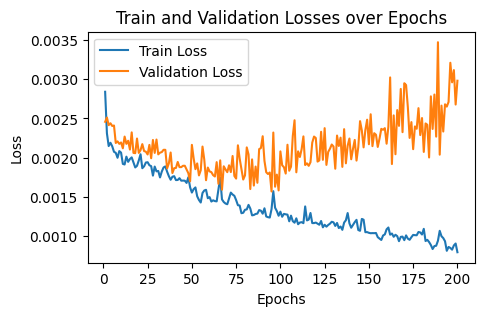

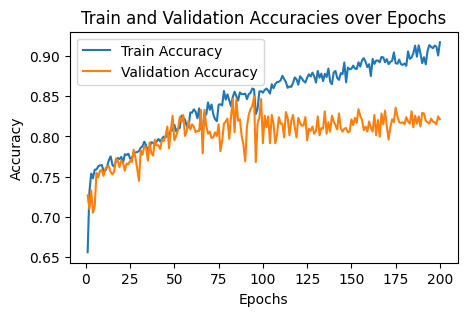

In [31]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [30]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/4000_Transformer_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 5/5 [00:00<00:00, 19.47it/s]

Best epoch: 95
macro F1 Score: 0.7689150357914067
AUROC: 0.9145727637116441
Accuracy: 0.8357271095152603


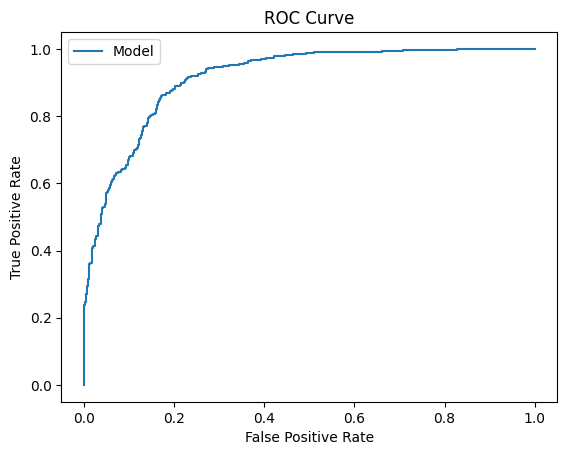

In [33]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)